# Exploración de datos TCGA-BRCA 27K

## Importar librerías y definir paths

In [1]:
import sys
from pathlib import Path

src_path = str(Path.cwd().parents[0] / "src")
if src_path not in sys.path:
    sys.path.append(src_path)

In [2]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
from eda_utils import violin_plot

data_preprocessed_path = str(Path.cwd().parents[0] / "data"/ "preprocessed")
data_raw_path = str(Path.cwd().parents[0] / "data" / "raw")

## Lectura

In [3]:
df = pd.read_csv(f"{data_preprocessed_path}/cpg_preprocessed.csv")
df.head()

,cg22501393,cg18895155,cg15264255,cg18464559,cg20379125,cg12790134,cg07697569,cg13613532,cg13951948,cg06590533,...,cg10265786,cg26848248,cg09906309,file_id,size,disease,sample_type,age,race,etnia
0,0.028667,0.012232,0.142088,0.016443,0.015846,0.117437,0.041592,0.024423,0.008772,0.014977,...,0.010114,0.022962,0.024748,fc6a1b6d-894e-4da5-be37-2b0b76770ab1,769178,Ductal and Lobular Neoplasms,Primary Tumor,28974.0,white,not hispanic or latino
1,0.029441,0.014666,0.106937,0.017454,0.016934,0.012831,0.018839,0.011539,0.010769,0.015953,...,0.010052,0.021182,0.028579,d42a557d-a77d-4f6b-8fb9-b5b6f4b3ea87,771468,Ductal and Lobular Neoplasms,Primary Tumor,20152.0,white,not hispanic or latino
2,0.034916,0.018333,0.113594,0.016953,0.018574,0.017720,0.019870,0.024152,0.008728,0.018683,...,0.010444,0.020363,0.029775,04e87399-3399-4fd9-93a0-7b8b4953c0c7,774870,Ductal and Lobular Neoplasms,Primary Tumor,25259.0,white,not reported
3,0.025584,0.014079,0.065338,0.018666,0.147531,0.109610,0.018852,0.021281,0.005948,0.014338,...,0.010144,0.045688,0.056429,47d4e8b4-c92b-4e06-a436-9fdc419ff70b,761724,Ductal and Lobular Neoplasms,Primary Tumor,19836.0,white,not hispanic or latino
4,0.027670,0.015868,0.071436,0.021284,0.014400,0.013111,0.019075,0.029269,0.011906,0.014320,...,0.009704,0.021215,0.025321,f947716e-8978-4e56-9a70-243b330c8e51,770436,Ductal and Lobular Neoplasms,Primary Tumor,23742.0,not reported,not reported


## Análisis de distribuciones

In [4]:
print("Conteo de tipos de muestra")
print(Counter(df['sample_type']))
print("Conteo de etnias")
print(Counter(df['etnia']))
print("Conteo de ascendencia")
print(Counter(df['race']))


Conteo de tipos de muestra
Counter({'Primary Tumor': 312, 'Solid Tissue Normal': 27})
Conteo de etnias
Counter({'not hispanic or latino': 232, 'not reported': 106, 'hispanic or latino': 1})
Conteo de ascendencia
Counter({'white': 213, 'not reported': 80, 'black or african american': 25, 'asian': 21})


In [5]:
# Transformar edades a años
df['age'] = df['age']/365.25

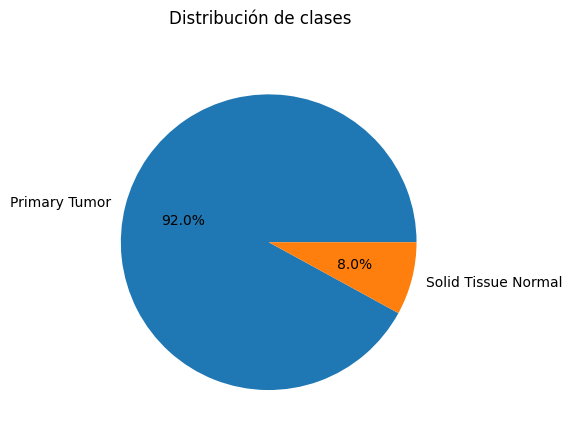

In [6]:
# Análizamos distribución
count = Counter(df['sample_type'])
fig, ax = plt.subplots()
fig.suptitle('Distribución de clases')
ax = ax.pie(count.values(), labels=count.keys(), autopct='%1.1f%%')

In [7]:
def histograms_comparison(hists, title='', x_axis=''):
    '''
        - hists: Diccionario con datos del eje x 
    '''
    
    fig = go.Figure()
    for label in hists:
        fig.add_trace(go.Histogram(x=hists[label], name = label))
        #fig.add_trace(go.Histogram(x=x2, name = label_2))
    # Overlay both histograms
    fig.update_layout(barmode='overlay')
    fig.update_layout(
        title = title,
        xaxis_title=x_axis,
        yaxis_title='Frequency'
    )
    # Reduce opacity to see both histograms
    fig.update_traces(opacity=0.85)
    fig.show()

In [8]:
tumor_samples = df[df['sample_type']=='Primary Tumor']
normal_samples = df[df['sample_type']=='Solid Tissue Normal']

In [9]:
histograms_comparison({'Tumor':tumor_samples['age'], 'Normal':normal_samples['age']},
                     'Distribución de edad', 'Edad')

In [10]:
histograms_comparison({'Tumor':tumor_samples['etnia'], 'Normal':normal_samples['etnia']},
                     'Distribución de etnia', 'Etnia')

In [11]:
histograms_comparison({'Tumor':tumor_samples['race'], 'Normal':normal_samples['race']},
                     'Distribución de ascendencia', 'Ascendencia')

## PCA

In [10]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [11]:
x, y = df.drop(columns = ['sample_type', 'race', 'etnia', 'file_id', 'size', 'disease']), df['sample_type']
x['age'] = MinMaxScaler().fit_transform(df[['age']])

pca = PCA(n_components=2)
x_pca = pca.fit_transform(x)

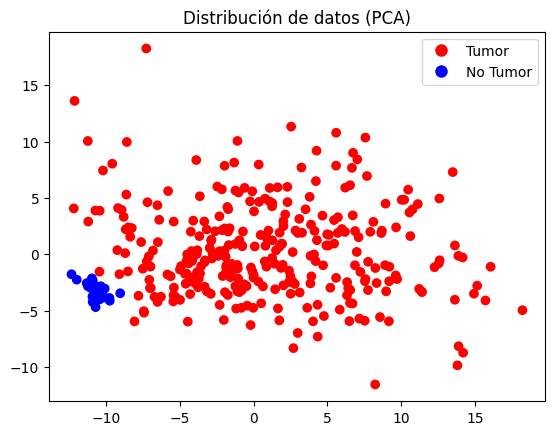

In [12]:
from matplotlib.lines import Line2D

plt.scatter(x_pca[:,0], x_pca[:,1], c =df['sample_type'].replace({'Solid Tissue Normal':'blue', 'Primary Tumor':'red'}) )

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Tumor',
                          markerfacecolor='red', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='No Tumor',
                          markerfacecolor='blue', markersize=10)]
plt.legend(handles=legend_elements, loc='upper right')

plt.title('Distribución de datos (PCA)')
plt.show()

## Correlaciones

In [13]:
df['tumor'] = df['sample_type'].replace({'Solid Tissue Normal':0, 'Primary Tumor':1 })

In [14]:
cpg_corr = df.corrwith(df['tumor'], numeric_only=True).abs().sort_values(ascending=False)
top_10_cpg = cpg_corr[1:11]

In [15]:
plot_data = df[top_10_cpg.index.tolist() + ['tumor']]
data_melted = plot_data.melt(id_vars='tumor', var_name='Feature', value_name='Value')

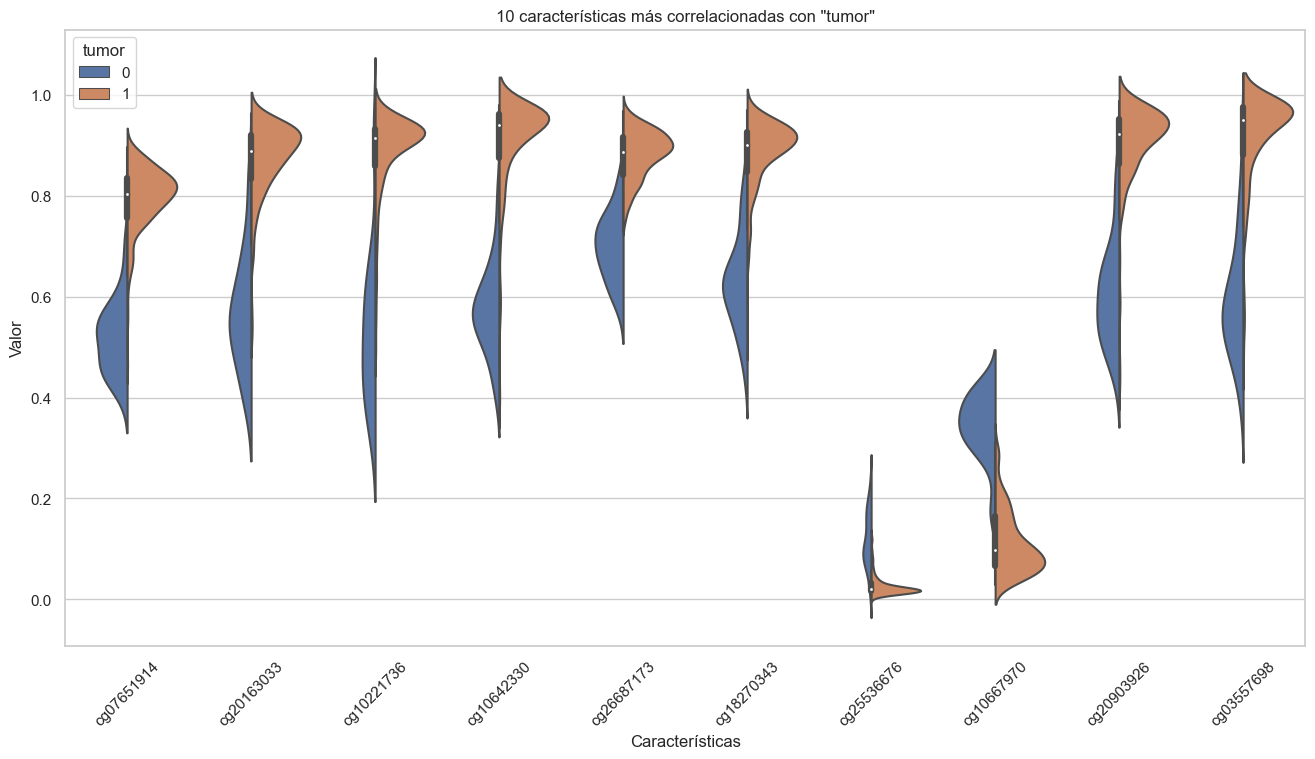

In [16]:
violin_plot(data_melted, 'Feature', 'Value', 'tumor', '10 características más correlacionadas con "tumor"')

## Relación de CpG con genes

### Lectura de manifiesto

In [17]:
df_manifest = pd.read_csv(f"{data_raw_path}/manifest.csv")
# Dejar sólo columnas importantes, quitar aquellas filas que no aparecen en Illumina 27k
manifest_no_na = df_manifest[["IlmnID", "UCSC_RefGene_Name", "Methyl27_Loci"]].dropna()
# Crear mapeo gen->lista de CpG
mapping = manifest_no_na[["IlmnID", "UCSC_RefGene_Name"]].groupby(by="UCSC_RefGene_Name").agg(lambda x: x.tolist())
mapping = mapping.reset_index()

C:\Users\drago\AppData\Local\Temp\ipykernel_13228\833732811.py:1: DtypeWarning:

Columns (2,4,11,14,15) have mixed types. Specify dtype option on import or set low_memory=False.



In [18]:
mapping['frec'] = mapping['IlmnID'].apply(lambda x: len(x))
mapping = mapping.sort_values(by='frec', ascending=False)

### Distribución de más comunes

In [19]:
features_genes = manifest_no_na[manifest_no_na.IlmnID.isin(df)]
common_genes = features_genes['UCSC_RefGene_Name'].value_counts()
top_5_genes = common_genes.index[:5]

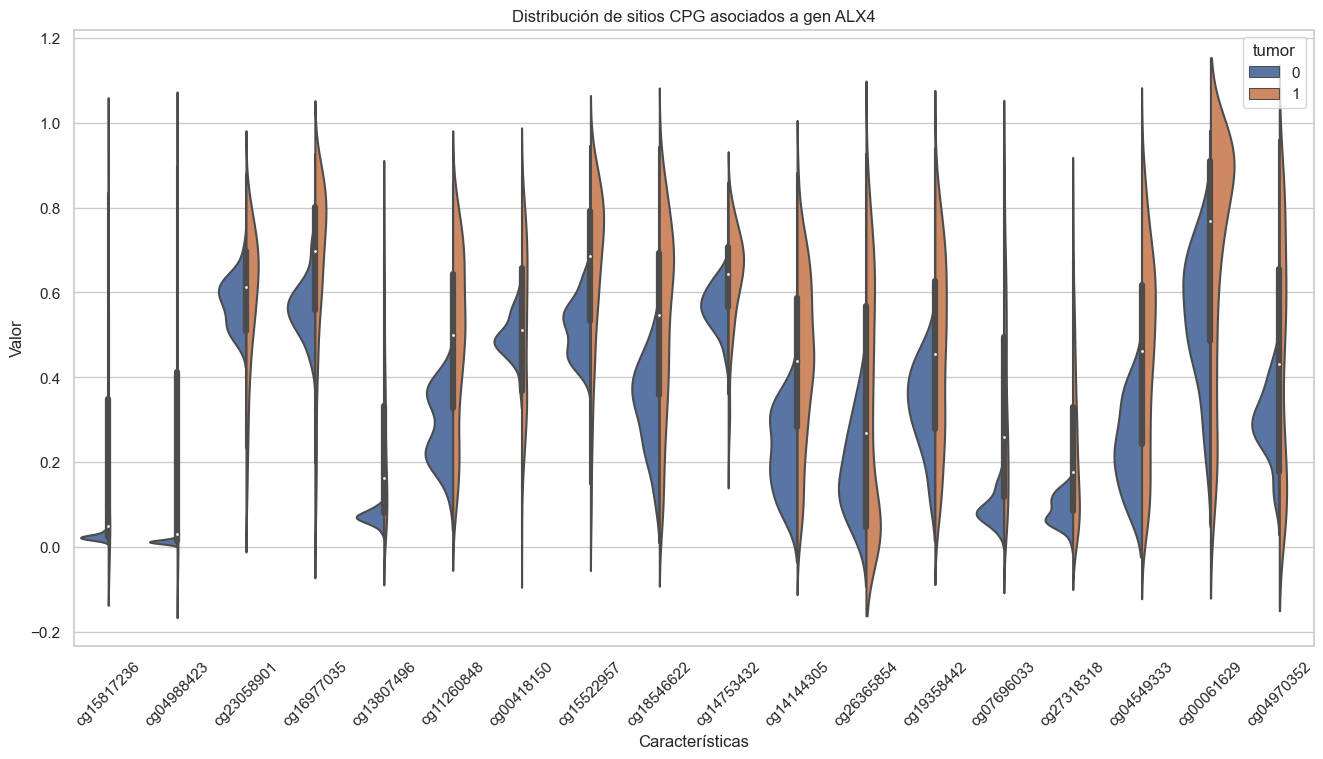

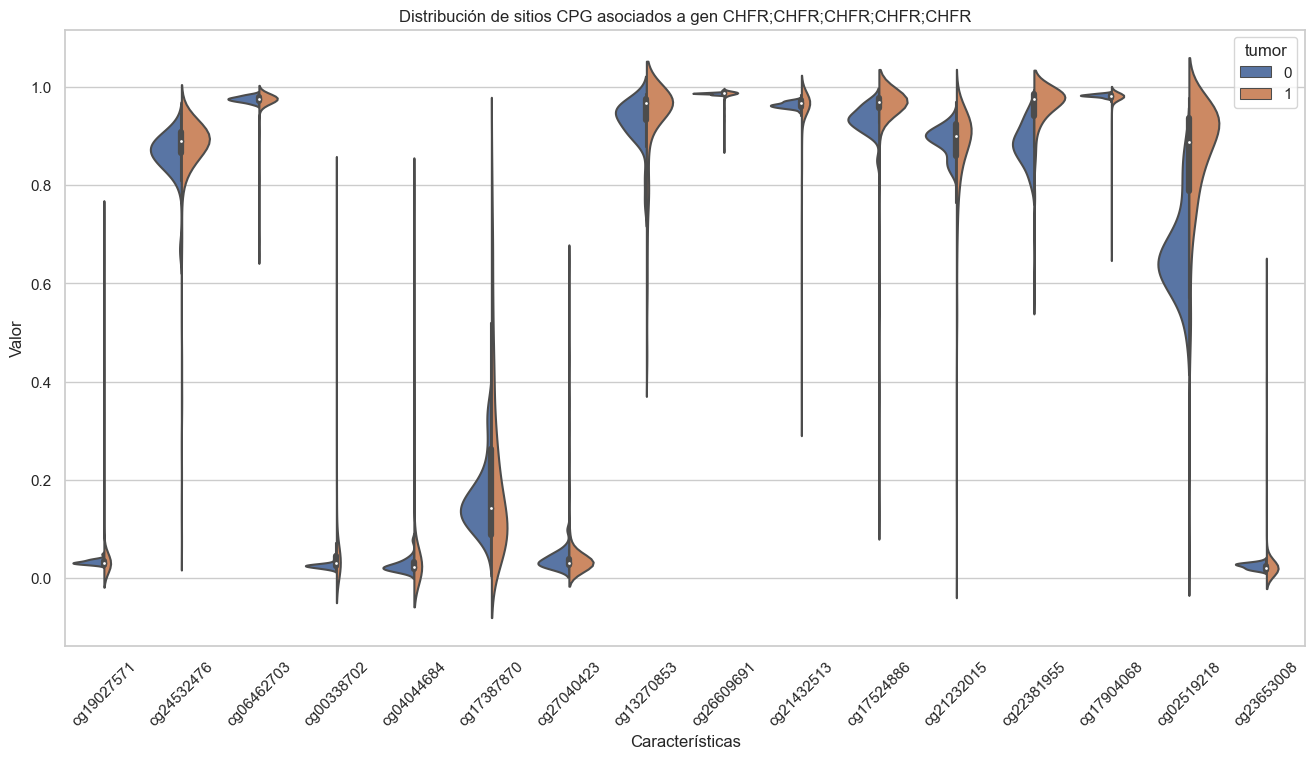

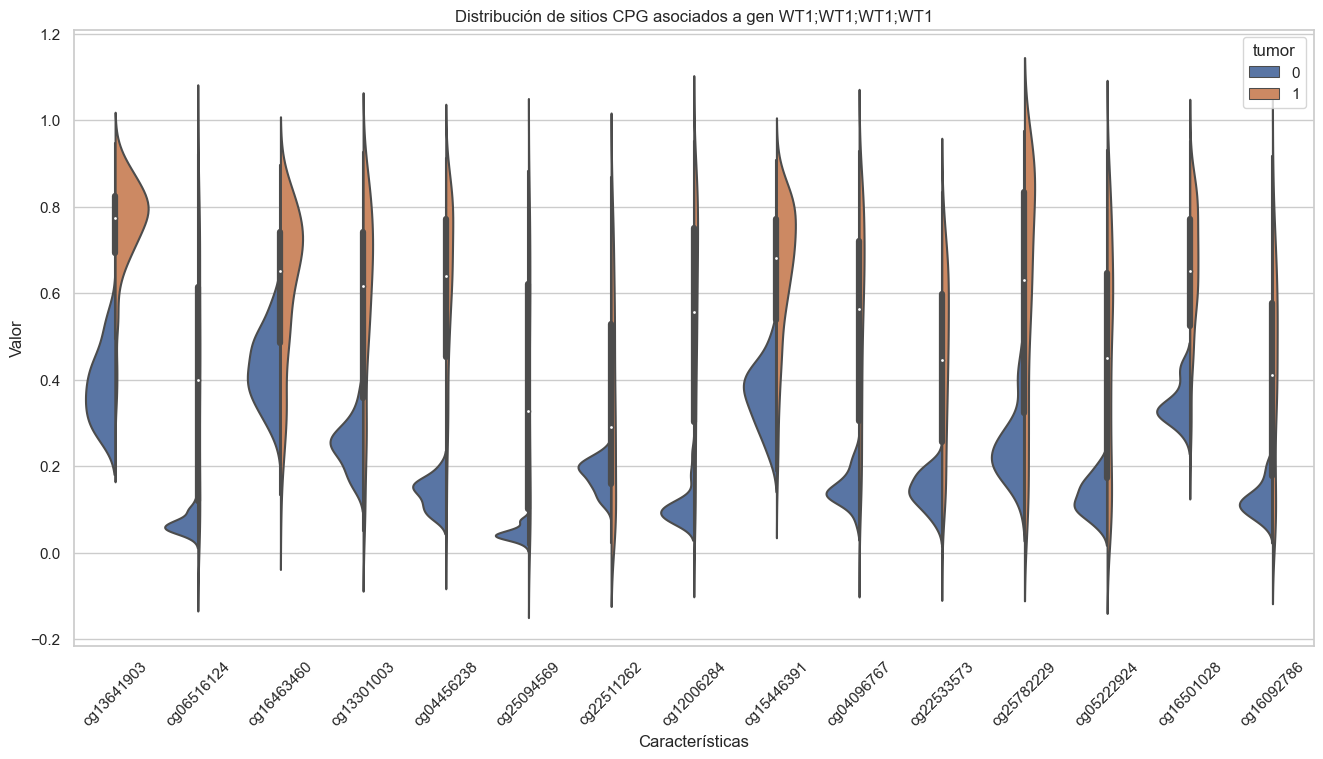

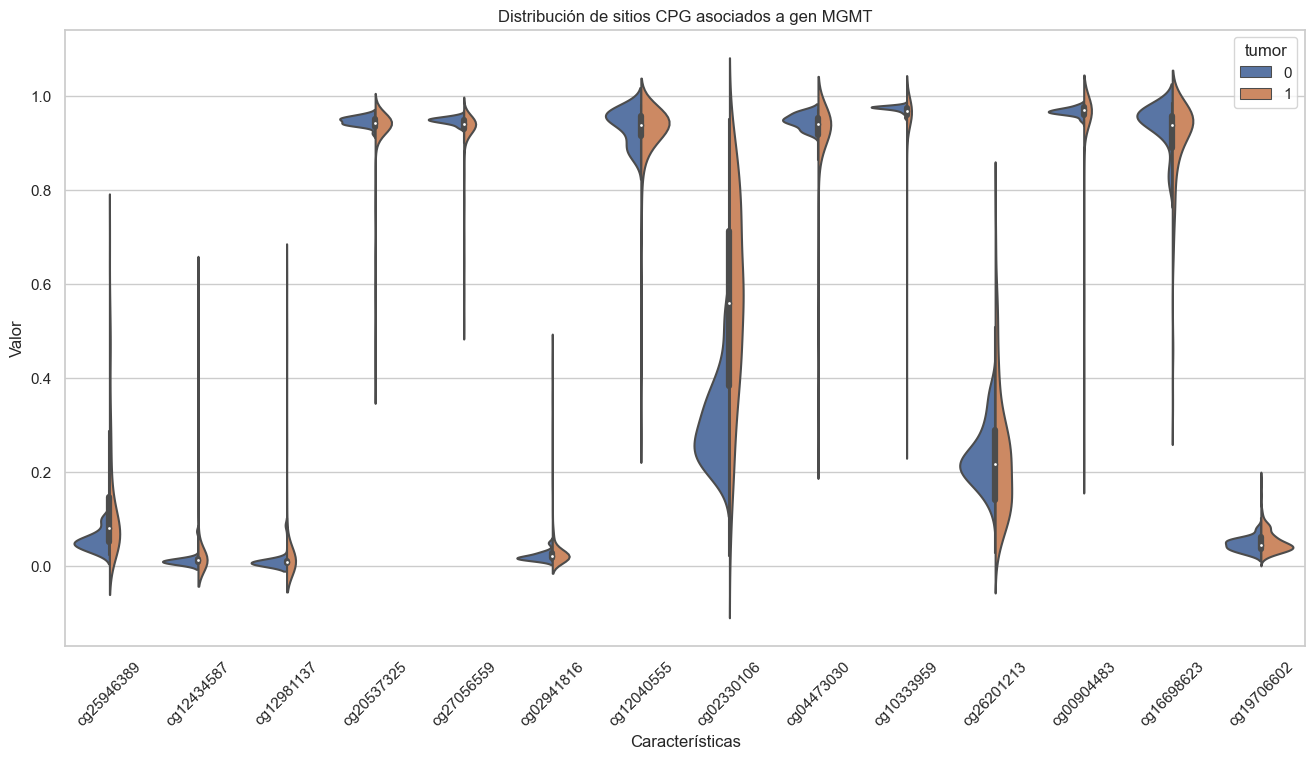

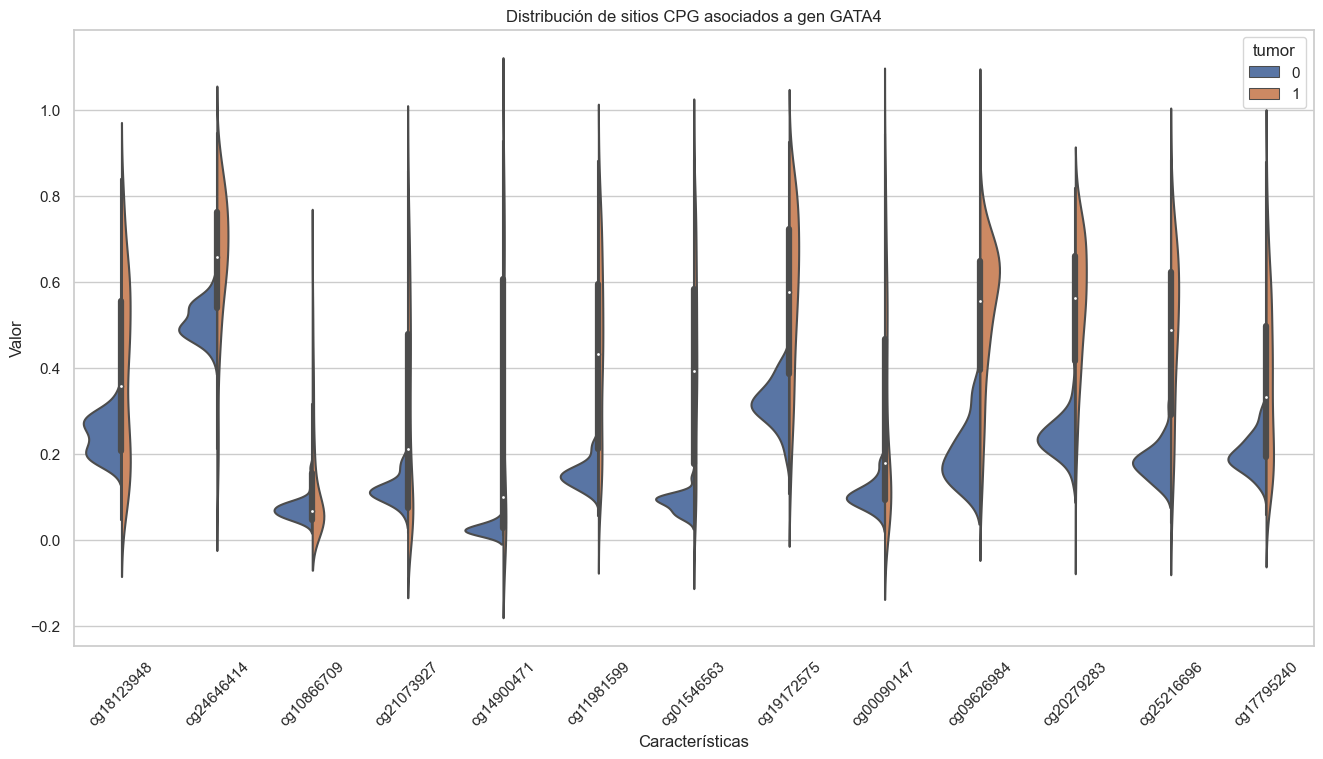

In [20]:
for gene in top_5_genes:
    cpgs = mapping[mapping['UCSC_RefGene_Name']==gene]['IlmnID'].iloc[0]
    gene_cpgs = df.loc[:, df.columns.isin(cpgs+['tumor'])]
    data_melted = gene_cpgs.melt(id_vars='tumor', var_name='Feature', value_name='Value')
    violin_plot(data_melted, 'Feature', 'Value', 'tumor', f'Distribución de sitios CPG asociados a gen {gene}')
    

#### Seleccionando CpGs

In [21]:
from gene_preprocessing import SelectByIterRF

In [22]:
x, y = df.drop(columns = ['file_id', 'size', 'disease', 'sample_type',
       'age', 'race', 'etnia', 'tumor']), df['sample_type']
x = SelectByIterRF().fit_transform(x, y)

In [23]:
features_genes = manifest_no_na[manifest_no_na.IlmnID.isin(x)]
common_genes = features_genes['UCSC_RefGene_Name'].value_counts()
top_3_genes = common_genes.index[:3]
top_3_genes

Index(['WT1;WT1;WT1;WT1', 'GATA4', 'KLK10;KLK10;KLK10'], dtype='object', name='UCSC_RefGene_Name')

In [24]:
pd.options.mode.chained_assignment = None 
top_3_df = []
for gene in top_3_genes:
    cpgs = mapping[mapping['UCSC_RefGene_Name']==gene]['IlmnID'].iloc[0]
    df_temp = df.loc[:, df.columns.isin(cpgs+['tumor'])]
    df_temp['cpg_mean'] = df_temp.drop(columns=['tumor']).mean(axis=1)
    top_3_df.append(df_temp)

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_mean_age(df_gene, gene='WT1'):
    fig = px.scatter(y=df_gene['cpg_mean'], x = df['age'], color = df_gene['tumor'].replace({1:'Tumor', 0:'No tumor'}),
           labels = {'x':'Edad', 'y': 'Promedio de CpG', 'color': 'Tumor'},
           title = f'Promedio CpG seleccionados vs Edad para gen {gene}')
    fig.show()
    
def heatmap_gene(df_gene, gene='WT1'):
       plt.figure(figsize=(12,6))
       hm = sns.heatmap(df_gene, yticklabels=False)
       plt.title(f'Heatmap Features de gen {gene}')
       plt.xticks(rotation=45)
       plt.show()

##### WT1

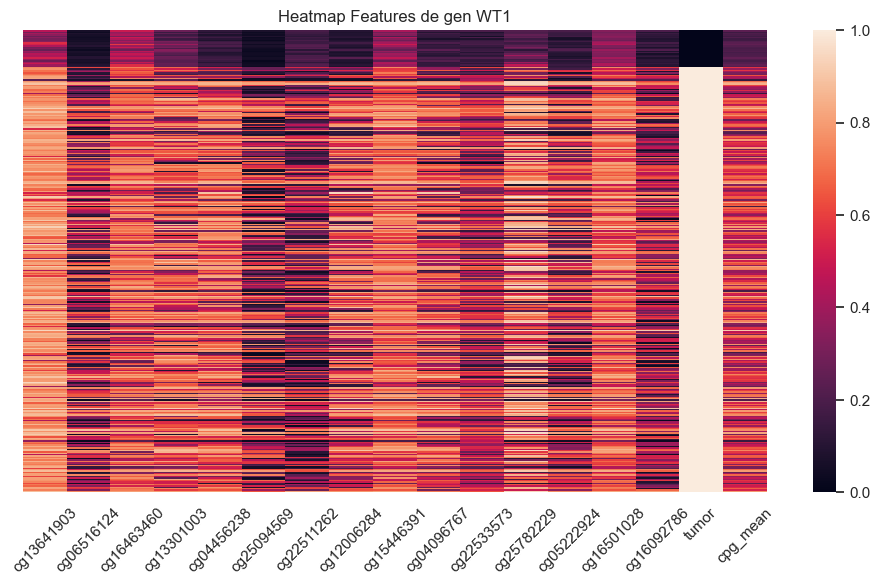

In [27]:

# Heatmap de features menos correlacionadas
df_wt1 = top_3_df[0].sort_values(by='tumor')
heatmap_gene(df_wt1)


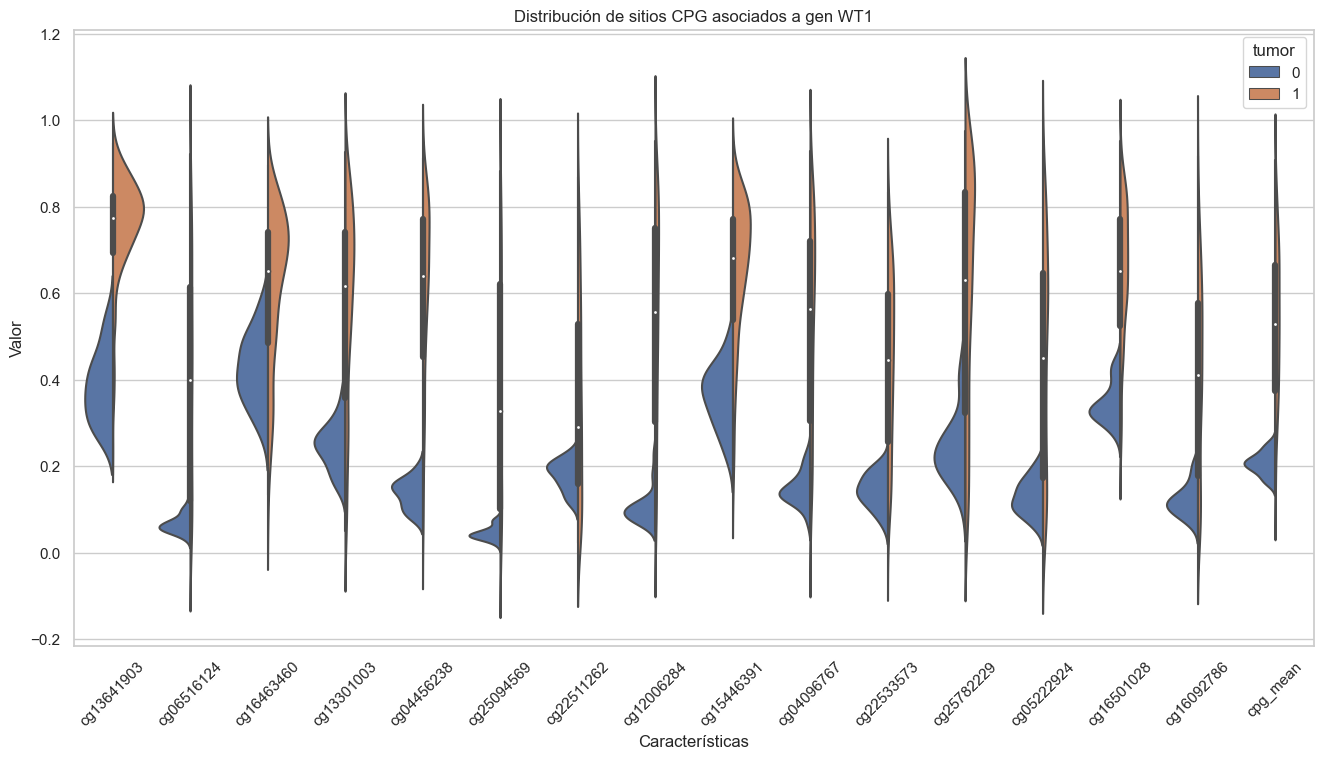

In [28]:
wt1_melted = df_wt1.melt(id_vars='tumor', var_name='Feature', value_name='Value')
violin_plot(wt1_melted, 'Feature', 'Value', 'tumor', 'Distribución de sitios CPG asociados a gen WT1')

In [73]:
plot_mean_age(df_wt1, 'WT1')

#### GATA4

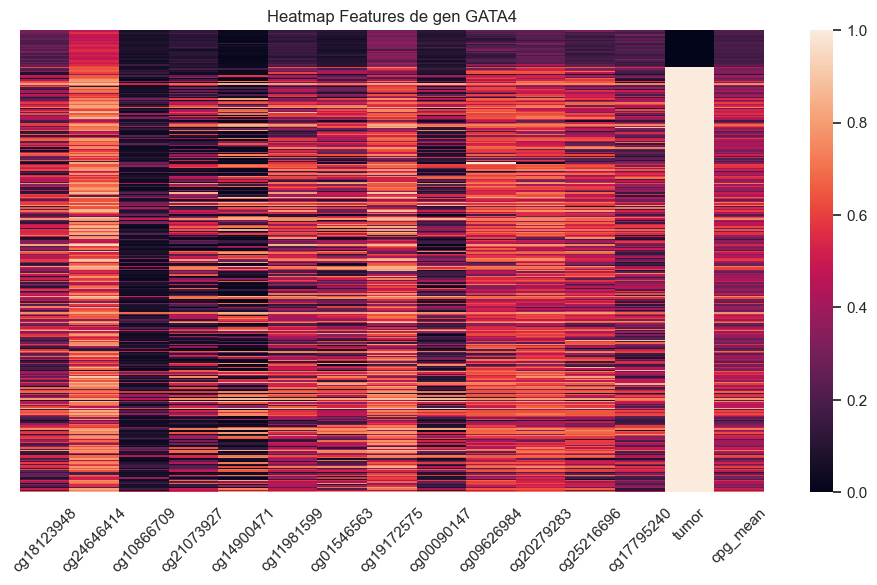

In [30]:
df_gata4 = top_3_df[1].sort_values(by='tumor')
heatmap_gene(df_gata4, 'GATA4')

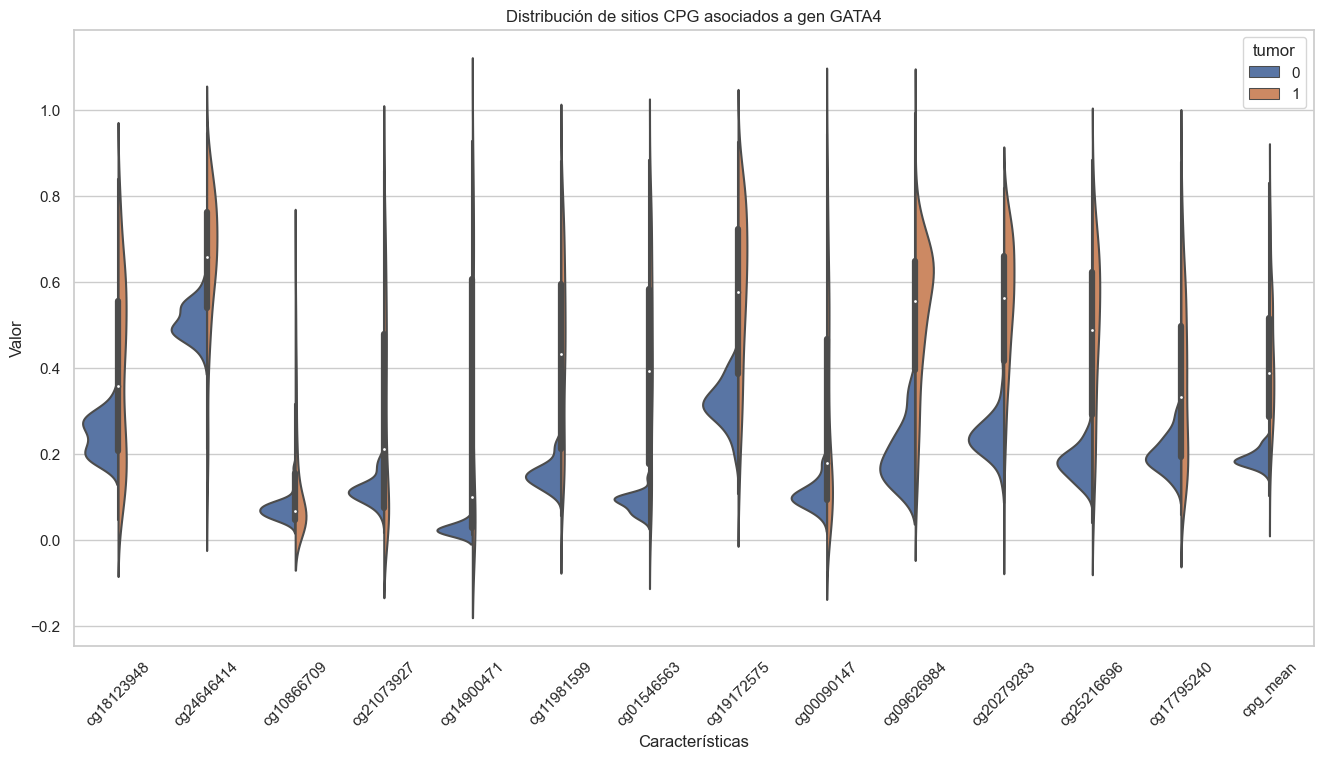

In [31]:
gata4_melted = df_gata4.melt(id_vars='tumor', var_name='Feature', value_name='Value')
violin_plot(gata4_melted, 'Feature', 'Value', 'tumor', 'Distribución de sitios CPG asociados a gen GATA4')

In [77]:
plot_mean_age(df_gata4, 'GATA4')

##### KLK10

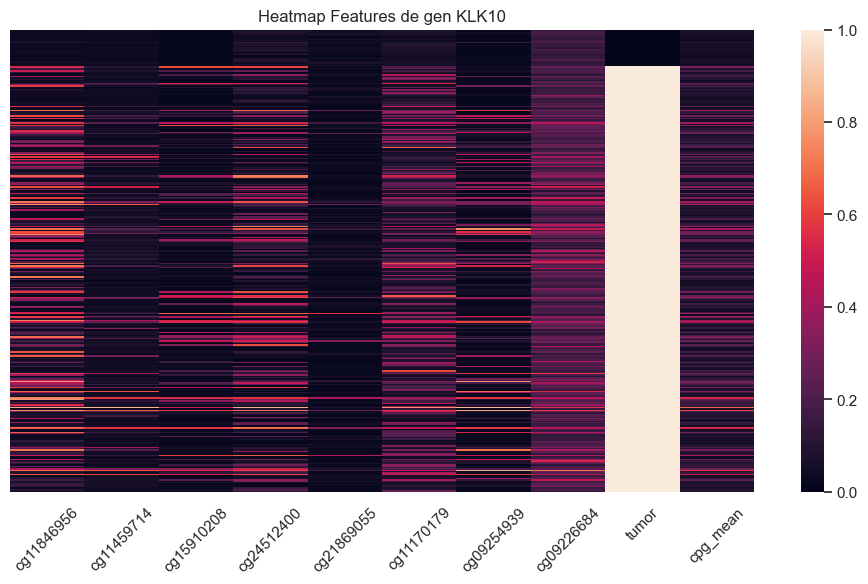

In [32]:
df_klk10 = top_3_df[2].sort_values(by='tumor')
heatmap_gene(df_klk10, 'KLK10')

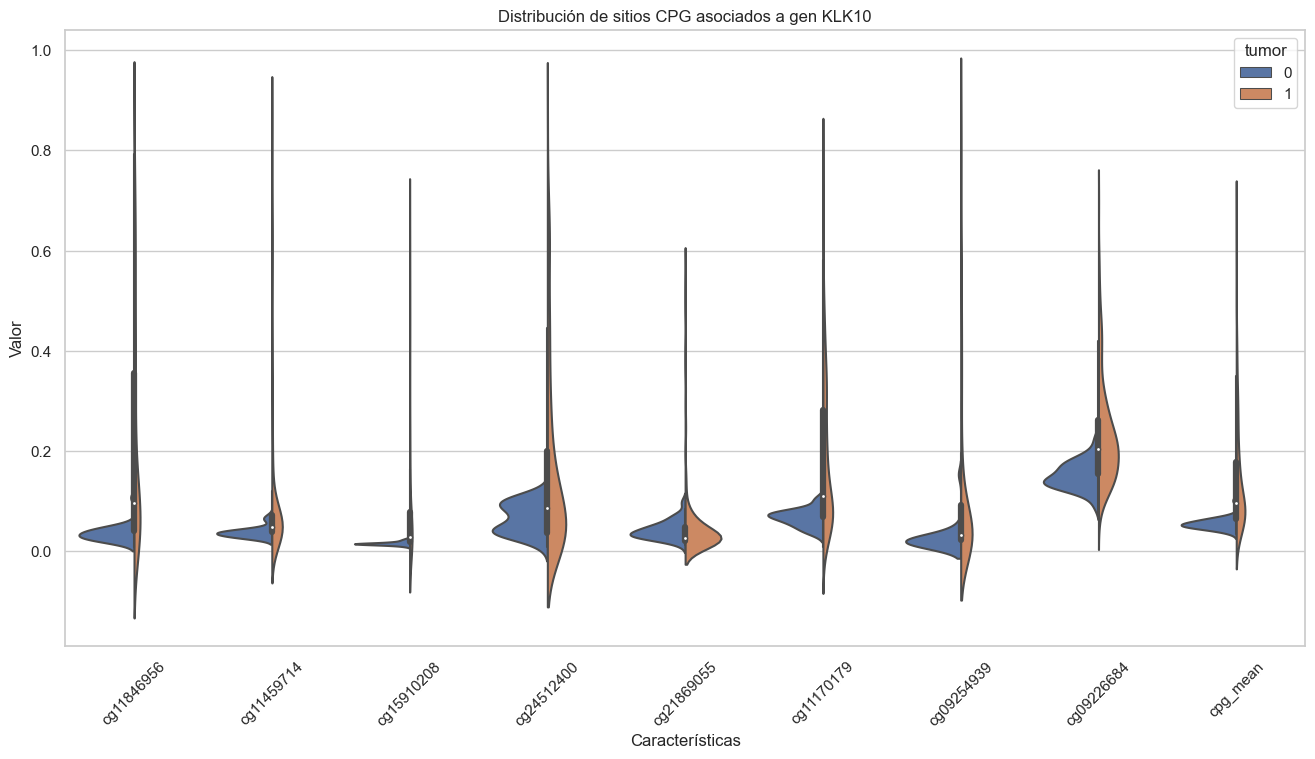

In [34]:
klk10_melted = df_klk10.melt(id_vars='tumor', var_name='Feature', value_name='Value')
violin_plot(klk10_melted, 'Feature', 'Value', 'tumor', 'Distribución de sitios CPG asociados a gen KLK10')

In [79]:
plot_mean_age(df_klk10, 'KLK10')